In [1]:
from IPython.display import display
import math
# import lux
import pandas as pd
import numpy as np
from astropy.time import Time
from pandas.core.reshape.tile import cut
import PlanetPos as PP
from JdUtils import stelJD
from time import time
import re
import NaksUtils
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

## Explore the duration between succesive Mars - Guru interaction

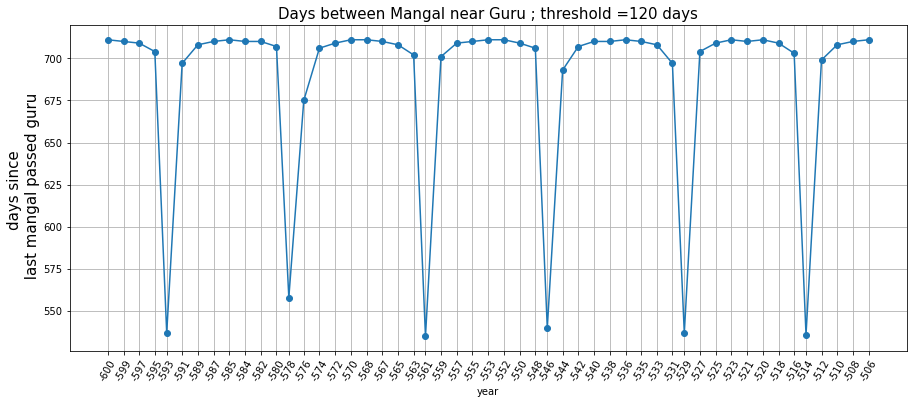

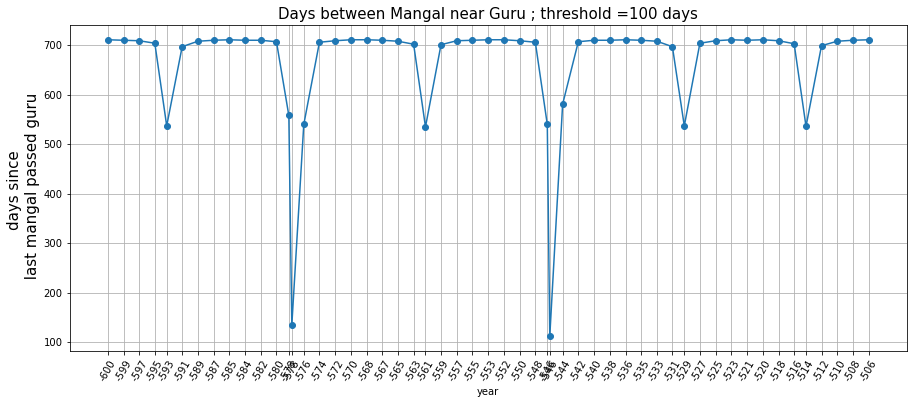

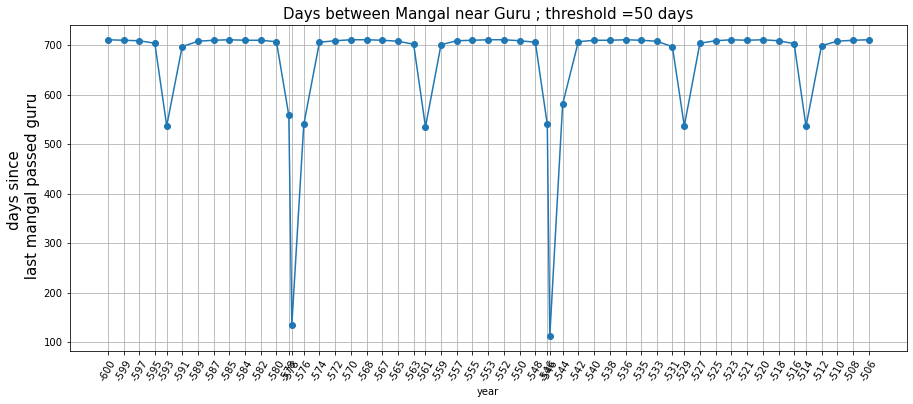

In [225]:
MARS_RETRO_CSV = "../datasets/mars-600bce-to-500bce-daily.csv"
try :
	mdf = pd.read_csv(MARS_RETRO_CSV)
except FileNotFoundError:
	bce600 = stelJD(-600,1,1,0,0)
	pp = PP.PlanetPos()
	t0 = time()
	mdf = pd.DataFrame()
	step=365
	for y in range(0,100*step,step) :
		ydf = pd.concat([ pp.get_planet_pos(bce600 + x ).loc[['Mars'],['jd', 'date', 'elong']] for x in range(y,y+step) ])
		mdf = pd.concat([mdf,ydf])
		print (f'{y//365 :4d} -- {y:6d} {y+step:6d} -- {time()-t0 :.2f}  -- {ydf.shape} {mdf.shape}')
		if (y//365)%10 == 0 :display(mdf.head(2), mdf.tail(2))

	mdf.to_csv(MARS_RETRO_CSV)
	display(mdf.head(), mdf.tail())

#%
def plot_mars_guru(threshold=120):
	tol=.8
	m1 = mdf[ [ (213.6-tol) < x < (213.6+tol) for x in mdf.elong ] ]
	m1['jdiff'] = m1.jd.diff().fillna(1)
	m1 = m1[m1.jdiff>threshold].reset_index()
	m1['jdiff'] = m1.jd.diff().fillna(1)
	m1 = m1.loc[1:,]
	m1['year'] = m1.date.apply(lambda x: int(re.sub("......T.*","",x)))
	ax=m1[m1.jdiff>1].plot(x='jd', y='jdiff', marker='o', rot=60, grid=True, figsize=(15,6), legend=None)
	ax.set_xticks(m1.jd)
	ax.set_xlabel('year')
	ax.set_ylabel('days since \n last mangal passed guru', fontsize=15)
	ax.set_xticklabels( [ -600+int(x-m1.jd[1])//365 for x in m1.jd] )
	ax.set_title(f'Days between Mangal near Guru ; {threshold =} days', fontsize=15)

plot_mars_guru()
plot_mars_guru(threshold=100)
plot_mars_guru(threshold=50)

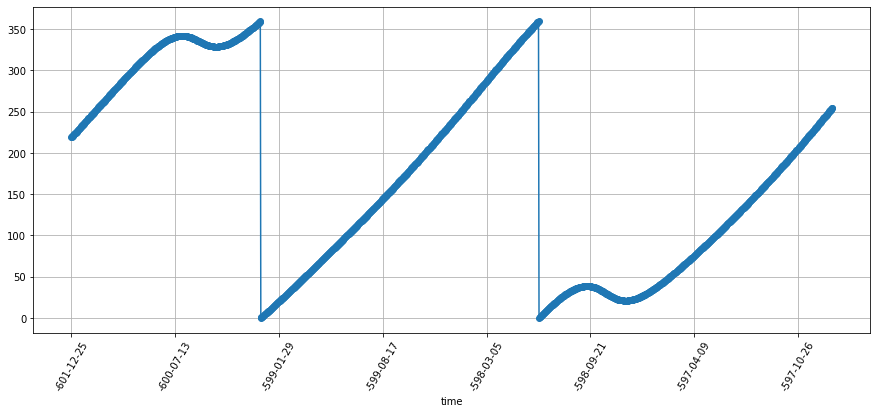

In [205]:
yrs = mdf.date.apply( lambda x: re.match("^(....)\-.*",x).groups()[0] )
mmm = mdf.date.apply( lambda x: re.match("^(..........).*",x).groups()[0] )
y600 = yrs.apply( lambda x: int(x) <= -597) # == '-600' or x == '-599' or x == '-598' or x == '-597')
mdf['time'] = mmm
m_ax = mdf[y600].plot( kind='line' , x='time', y='elong', marker='o', rot=60, grid=True, figsize=(15,6), legend=None)
# m_ax.set_xticklabels( [ re.sub("...$","",d.get_text()) for  d in m_ax.get_xticklabels()] );
# m_ax.set_xticklabels( [ d.get_text() if re.match(".",d.get_text()) else "" for  d in m_ax.get_xticklabels()] );


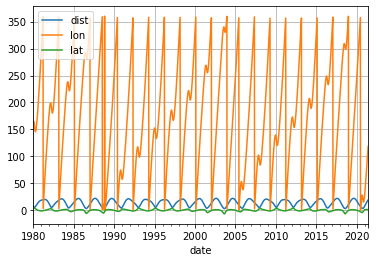

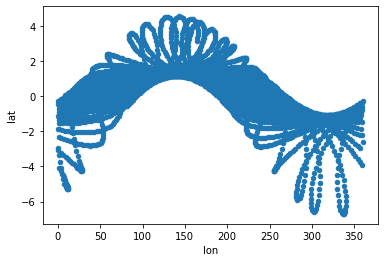

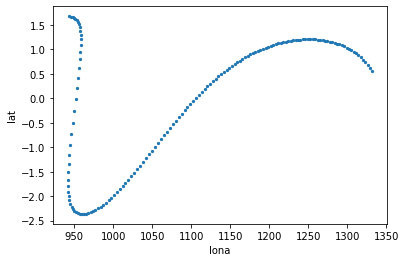

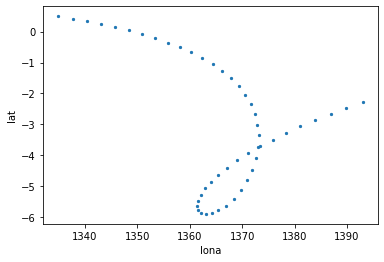

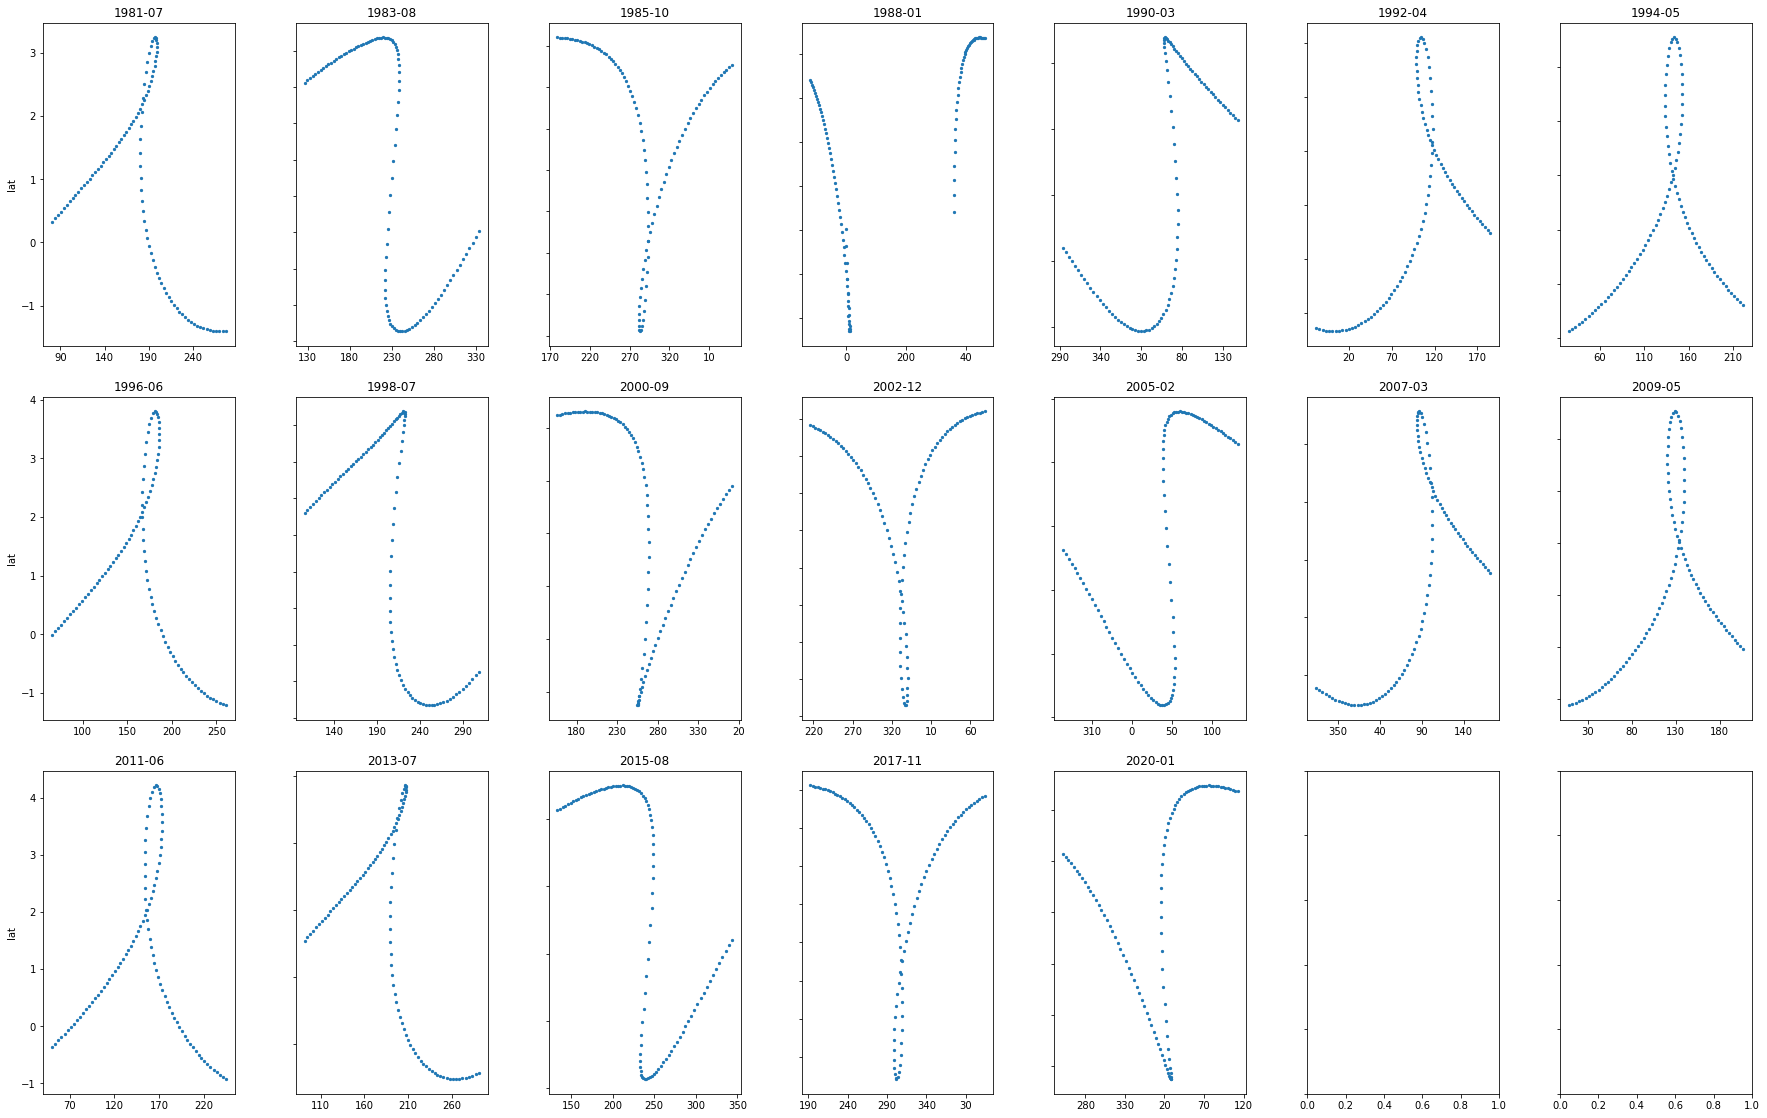

In [13]:

# dtypes = [str, str, float, float, float]
mr = pd.read_csv("../datasets/mars-retro.txt", sep="\t").drop(columns=['hhmm'])
mr.date = pd.to_datetime(mr.date)
mr = mr.set_index('date')
mr
ax = mr.plot()
_= ax.grid()
# %%

_ = mr.plot(kind='scatter', x="lon", y="lat")

# %%
f=0
ans =[]
for d ,l in zip(mr.lon.diff() , mr.lon) :
  if d < -300 : f+=1
  ans.append( l + f*360)

mr['lona'] = ans
_ = mr[300:450].plot(kind='scatter', x="lona", y="lat", marker='.')
# %%
_ = mr[450:500].plot(kind='scatter', x="lona", y="lat", marker='.')

# %%
mr['ldiff'] = mr.lon.diff()
mr['retro'] = mr.ldiff.apply( lambda x: 1 if x < -1 and x >-300 else 0)
mr1 = mr.reset_index()
mr1 = mr1[mr1.retro==1]
idx = pd.Series(mr1.index)
idxd = idx.diff()
idx[idxd>1].shape

#%%
fig, axs = plt.subplots(3,7, figsize=(25,16))
fig.tight_layout(pad=3.0)
for span,ax in zip(idx[idxd>1], axs.flatten()) :
  mrx = mr[span-50:span+50]
  mrx.plot(ax=ax, kind='scatter', 
  x="lona", y="lat", marker='.', 
  sharey=True,
  title=re.sub(".\d\d\s00:00:00","",str(mrx.index[0]))) 
  ax.set_xlabel("")
  # ax.set_xticklabels([ t.get_text() for t in ax.get_xticklabels()])
  # print([ int(t%360) for t in ax.get_xticks()])
  _ = ax.set_xticklabels([ int(t%360) for t in ax.get_xticks()])

# %%


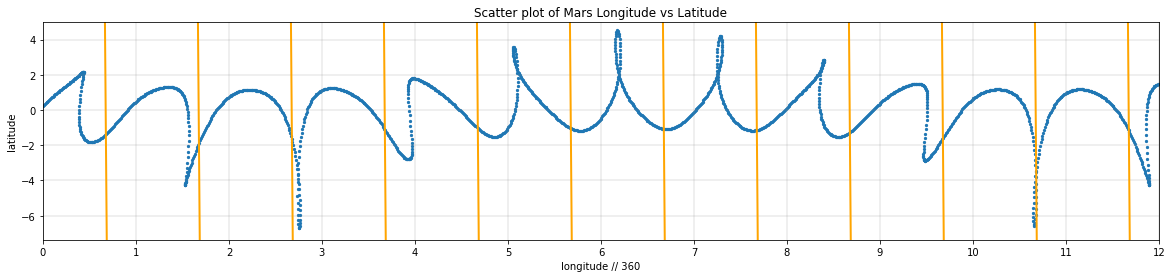

In [148]:
mr1= mr.reset_index()
ix = mr1[mr1.lon<5].index.values[7]
mr1=mr1.iloc[ix+720:ix+4600]
mr1['lonb'] = mr1.lona - mr1.lona.min()
m_ax = mr1.plot.scatter(x="lonb", y="lat", marker='.', figsize=(20,4))

m_ax.set_xticks(range(int(mr1.lonb.min()), int(mr1.lonb.max()), 360))
m_ax.set_xticklabels( [ int(t//360) for t in m_ax.get_xticks()])
m_ax.set_xlabel("longitude // 360")
m_ax.set_ylabel("latitude")
for i in range( -1, 13) :
    # m_ax.plot([240+i*360,240+i*360], [mr1.lonb.min(),mr1.lonb.max()], lw=2, color='orange')
    m_ax.plot([247+i*360,240+i*360], [mr1.lat.min()*1.1,mr1.lat.max()*1.1], lw=2, color='orange')

m_ax.set_title("Scatter plot of Mars Longitude vs Latitude")
m_ax.set_xlim(0,360*12)
m_ax.set_ylim(mr1.lat.min()*1.1,mr1.lat.max()*1.1)
m_ax.grid(color='gray', lw=.25)


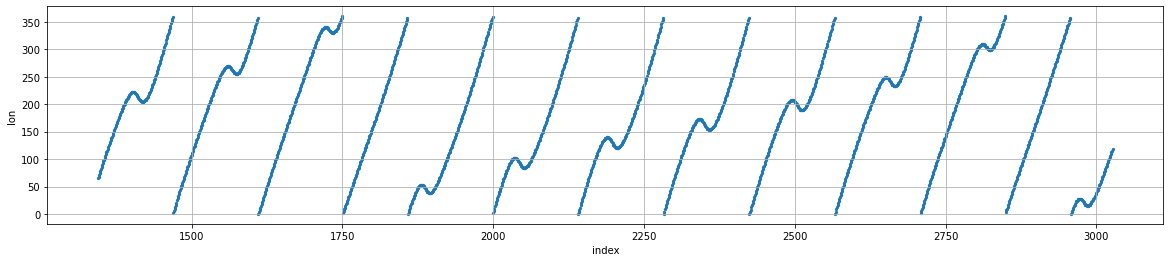

In [220]:
m_ax = mr1.reset_index().plot.scatter(x="index", y="lon", secondary_y = 'lat', marker='.', figsize=(20,4), grid=True)
# mr1.reset_index().plot(x="index", y="lat", marker='.', secondary_y=True, ax=m_ax, color='gray')

In [11]:
!rm ./mars_retro.html 2>/dev/null
!date
!`which jupyter` nbconvert mars_retro.ipynb --to html --no-input --output  mars_retro.html 2>&1 | tee ~/tmp/nbconvert.log
!open ./mars_retro.html

Mon Apr 25 13:23:41 IST 2022
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook mars_retro.ipynb to html
[NbConvertApp] Writing 953337 bytes to mars_retro.html


In [117]:
mr

,dist,lon,lat,lona,ldiff,retro
date,,,,,,
1980-01-01,8.040461,163.971307,3.129889,163.971307,NaN,0
1980-01-06,7.696647,164.708064,3.290195,164.708064,0.736757,0
1980-01-11,7.366089,165.174530,3.453667,165.174530,0.466466,0
1980-01-16,7.052242,165.346125,3.617850,165.346125,0.171594,0
1980-01-21,6.759171,165.201842,3.779334,165.201842,-0.144283,0
...,...,...,...,...,...,...
2021-05-20,18.027259,106.148454,1.398979,8386.148454,3.057851,0
2021-05-25,18.325147,109.210020,1.383756,8389.210020,3.061567,0
2021-05-30,18.613022,112.275475,1.367485,8392.275475,3.065454,0


In [223]:

mr

,dist,lon,lat,lona,ldiff,retro
date,,,,,,
1980-01-01,8.040461,163.971307,3.129889,163.971307,NaN,0
1980-01-06,7.696647,164.708064,3.290195,164.708064,0.736757,0
1980-01-11,7.366089,165.174530,3.453667,165.174530,0.466466,0
1980-01-16,7.052242,165.346125,3.617850,165.346125,0.171594,0
1980-01-21,6.759171,165.201842,3.779334,165.201842,-0.144283,0
...,...,...,...,...,...,...
2021-05-20,18.027259,106.148454,1.398979,8386.148454,3.057851,0
2021-05-25,18.325147,109.210020,1.383756,8389.210020,3.061567,0
2021-05-30,18.613022,112.275475,1.367485,8392.275475,3.065454,0


In [227]:
mdf

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [270]:
# mdf.apply ( lambda x: x.date.apply( lambda y: re.match("^(....)\-.*",y).groups()[0] ) , axis=1)
# yyyy = mdf.apply( lambda x: re.match("^(....)",x.date).groups(0)[0] , axis=1)
mdf.assign(
    zx1=mdf.date.apply( lambda x: int(re.match("^(....)",x).groups(0)[0]) ),
    # zx2=lambda x : x.zx1.apply( lambda y: y <= -600)
    zx2=lambda x : x.zx1 * x.zx1
    )

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [3]:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz

observing_location = EarthLocation(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
observing_time = Time('2017-02-05 20:12:18')  
aa = AltAz(location=observing_location, obstime=observing_time)

coord = SkyCoord('4h42m', '-38d6m50.8s')
coord.transform_to(aa)

<SkyCoord (AltAz: obstime=2017-02-05 20:12:18.000, location=(3871196.57989284, -568949.21128116, 5020178.6461387) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180.18095975, -0.34268787)>

In [4]:
observing_time.jd

2457790.341875

In [6]:
Time(0, format='jd').fits

'-04713-11-24T12:00:00.000'